In [96]:
using DataFrames, CSV, Plots, JuMP, HiGHS, Statistics
import Dates
ENV["ROWS"]=120

120

In [221]:
timeseries = CSV.read("Data/time_series_60min_singleindex.csv", DataFrame)
columns = names(timeseries)
to_keep = columns[occursin.("GB",columns) .& occursin.("profile",columns) .& (occursin.("wind",columns) .| occursin.("solar",columns))]
to_keep_ts = vcat(columns[1], to_keep)

timeseries = timeseries[!,to_keep_ts]
CSV.write("Data/timeseries_uk_erv.csv", timeseries)

#We'll create a TMY with the Solar data, Onshore wind data and offshore data
timeseries[!,"timestamp"] = Dates.DateTime.(timeseries[!,"utc_timestamp"],"yyyy-mm-ddTHH:MM:SSZ");
# We filter the data so we don't have missing values anywhere
timeseries_dict = Dict()
for column in to_keep
    timeseries_dict[column] = timeseries[.!ismissing.(timeseries[!,column]),["timestamp",column]]
end

# From each date, we save the year, month, day and hour, as the data is hourly
for column in to_keep
    timeseries_dict[column][!,"year"] = Dates.year.(timeseries_dict[column][!,"timestamp"])
    timeseries_dict[column][!,"month"] = Dates.month.(timeseries_dict[column][!,"timestamp"])
    timeseries_dict[column][!,"day"] = Dates.day.(timeseries_dict[column][!,"timestamp"])
    timeseries_dict[column][!,"hour"] = Dates.hour.(timeseries_dict[column][!,"timestamp"])
end

long_term_data = Dict()
long_term_year = Dict()
# Now, we group by month and day so we can get the average capacity factor
for element in timeseries_dict
    name, df = element
    df = element[2];
    gdf = groupby(df, [:month, :year])
    gdf = combine(gdf, name .=> mean => name)
    long_term_data[name] = gdf

    df = gdf;
    gdf = groupby(df, :month)
    gdf = combine(gdf, name .=> mean => name)
    long_term_year[name] = gdf
end

upper, lower = max(long_term_data["GB_GBN_solar_profile"][!,:year]...),min(long_term_data["GB_GBN_solar_profile"][!,:year]...)
years = upper-lower;


In [78]:
monthly_avg = Dict()
for element in timeseries_dict
    name, df = element
    avgs = []
    for k in 1:12
        avg = mean(df[df.month.==k,name])
        push!(avgs,avg)
    end
    monthly_avg[name] = avgs
end

avg_data = Dict()
for element in timeseries_dict
    name, df = element
    avg_matrix = []
    for k in 1:12
        yearly_means = []
        for j in lower:upper
            yearly_mean = mean(df[(df.month.==k) .& (df.year.==j),name])
            push!(yearly_means,yearly_mean)
        end
        push!(avg_matrix,yearly_means)  
    end
    avg_data[name] = avg_matrix
end


In [134]:
TMYS = Dict()
for element in avg_data
    name, matrix = element
    best_value = monthly_avg[name]
    df = timeseries_dict[name][!,["timestamp",name, "month", "year"]]
    TMY = DataFrame([[],[],[],[]], ["timestamp",name,"year","month"])
    best_years = []
    for k in 1:12
        error = abs.(matrix[k].-best_value[k])
        best_year = findall(x->x==min(error...), error).+lower.-1
        best_year_df = df[(df.month.==k) .& (df.year.==best_year),["timestamp",name,"year","month"]]
        TMY = vcat(TMY,best_year_df)
        push!(best_years,best_year)
    end
    TMYS[name] = TMY
    CSV.write("TMY_"*name*".csv", TMY)
end

In [210]:
plots = []
for element in long_term_year
    name, df = element
    df_tmy = TMYS[name]
    df_raw = timeseries_dict[name]
    df_tmy = groupby(df_tmy, :month)
    df_tmy = combine(df_tmy, name .=> mean => name)
    display_parts = titlecase.(split(name,"_"));
    display_name = join(display_parts[3:end]," ");
    plot(df[!,:month],df[!,name],label="Long Term",color="orange",legend=:topleft, title=display_name)
    for k in lower:upper
        df_year = df_raw[df_raw.year.==k,:]
        df_year = groupby(df_year, :month)
        df_year = combine(df_year, name .=> mean => name)
        plot!(df_year[!,:month],df_year[!,name],label="", color="blue", alpha=0.25)
    end
    p=plot!(df_tmy[!,:month],df_tmy[!,name],label="TMY", color="green")
    push!(plots,p)
end
plot(plots..., layout=(4,1), size=(1000,1000), yformatter=y->string(trunc(Int,100*y))*"%", show=true)
xticks!(1:12,["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"])
savefig("Results/TMY_comparison.png")

"c:\\Users\\nacho\\Desktop\\Imperial College\\Spring Term\\Power System Planning\\PowerSystemPlanning_CW\\Results\\TMY_comparison.png"

In [4]:
generators = CSV.read("CostsData.csv",DataFrame);
G = generators.Gen;

# Separate the generators into renewable and conventional
G_erv = G[occursin.("Wind",G) .| occursin.("Solar",G)];
G_conv = G[G.∉ Ref(G_erv)];

# We want to select the columns that do work for us. We will remove those in kW
columns = names(generators)
to_use = columns[.!occursin.("KW",columns) .& .!occursin.("Gen",columns)]

gen_data = Dict()
for column in to_use
    colname = split(column)[1]
    gen_data[colname] = JuMP.Containers.DenseAxisArray(generators[!,column],G)
end

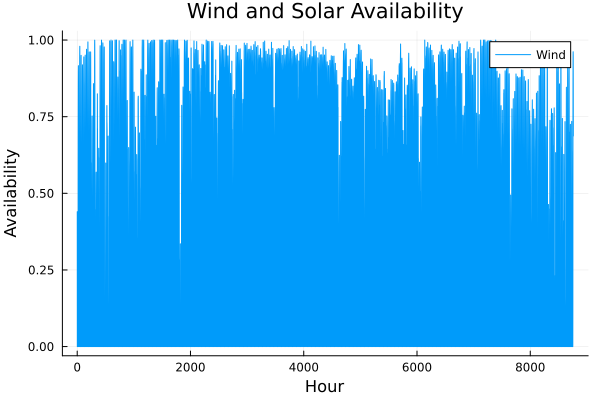

In [5]:
availability = CSV.read("wind_solar_for_expansion.csv",DataFrame)
plot(availability[!,:Hour],availability[!,:Solar],label="Wind",xlabel="Hour",ylabel="Availability",title="Wind and Solar Availability")

In [6]:
demand = CSV.read("Demand_for_expansion.csv",DataFrame)
D = demand.Demand;
H = demand.Hour;

In [7]:
FirstExpansionModel = Model(HiGHS.Optimizer)
@variables(FirstExpansionModel,begin
    CAP[g in G] >= 0
    GEN[g in G, h in H] >= 0
    NSE[h in H] >= 0
end);

@constraints(FirstExpansionModel,begin
    demandBalance[h in H], sum(GEN[g,h] for g in G) + NSE[h] == D[h]
    capacityBound[g in G_conv, h in H], GEN[g,h] <= CAP[g]*gen_data["CapacityFactor"][g]
end)

(1-dimensional DenseAxisArray{ConstraintRef{Model, MathOptInterface.ConstraintIndex{MathOptInterface.ScalarAffineFunction{Float64}, MathOptInterface.EqualTo{Float64}}, ScalarShape},1,...} with index sets:
    Dimension 1, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  8751, 8752, 8753, 8754, 8755, 8756, 8757, 8758, 8759, 8760]
And data, a 8760-element Vector{ConstraintRef{Model, MathOptInterface.ConstraintIndex{MathOptInterface.ScalarAffineFunction{Float64}, MathOptInterface.EqualTo{Float64}}, ScalarShape}}:
 demandBalance[1] : GEN[OnshoreWind,1] + GEN[OffshoreWind,1] + GEN[Solar,1] + GEN[Hydro-Dam,1] + GEN[Hydro-RoR,1] + GEN[Nuclear,1] + GEN[Biomass,1] + GEN[Coal,1] + GEN[Gas-CC,1] + GEN[Gas-CT,1] + NSE[1] == 2274
 demandBalance[2] : GEN[OnshoreWind,2] + GEN[OffshoreWind,2] + GEN[Solar,2] + GEN[Hydro-Dam,2] + GEN[Hydro-RoR,2] + GEN[Nuclear,2] + GEN[Biomass,2] + GEN[Coal,2] + GEN[Gas-CC,2] + GEN[Gas-CT,2] + NSE[2] == 2581
 demandBalance[3] : GEN[OnshoreWind,3] + GEN[OffshoreWind,3] + GEN[Solar,3] 